## Machine Learning Project 2

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch

In [2]:
data = pd.read_csv('/Users/jaxen1/Shared/C/Machine Learning/project2/project_adult.csv')
validation = pd.read_csv('/Users/jaxen1/Shared/C/Machine Learning/project2/project_validation_inputs.csv')

In [14]:
data = pd.read_csv('project_adult.csv')
validation = pd.read_csv('project_validation_inputs.csv')
print(data.head())

   Unnamed: 0  age         workclass  fnlwgt     education  education-num  \
0        5514   33         Local-gov  198183     Bachelors             13   
1       19777   36           Private   86459     Assoc-voc             11   
2       10781   58  Self-emp-not-inc  203039           9th              5   
3       32240   21           Private  180190     Assoc-voc             11   
4        9876   27           Private  279872  Some-college             10   

       marital-status       occupation   relationship   race     sex  \
0       Never-married   Prof-specialty  Not-in-family  White  Female   
1  Married-civ-spouse  Exec-managerial        Husband  White    Male   
2           Separated     Craft-repair  Not-in-family  White    Male   
3  Married-civ-spouse  Farming-fishing        Husband  White    Male   
4            Divorced    Other-service  Not-in-family  White    Male   

   capital-gain  capital-loss  hours-per-week native-country income  
0             0             0     

## Data Preprocessing

In [28]:
# Function to preprocess data
def preprocess_data(df):
    # Take out educational since is ordinal, ordinal var is already in dataset
    df = df.drop(columns = ['Unnamed: 0', 'education'])
    # Handle missing values
    df = df.dropna()
    # Replace all values unknown with most common ('Private')
    df['workclass'] = df['workclass'].apply(lambda x: df['workclass'].value_counts().index[0] if x == '?' else x)

    # TRY EXCEPT SO VALIDATION SET CAN PASS
    # Binarize the target variable
    try:
        df['income'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)
    except:
        pass

    # keep track of rows indexes to connect X and y
    df = df.reset_index()

    # Deal with Categorical Values

    # initialize encoder
    encoder = OneHotEncoder(sparse_output=False)
    # pull categorical cols
    categorical_cols = df.select_dtypes(include='object').columns
    # create encoded array w one hot columns
    encoded_array = encoder.fit_transform(df[categorical_cols])
    # Get new column names
    encoded_cols = encoder.get_feature_names_out(categorical_cols)
    # Creae new df of encoded columns
    encoded_df = pd.DataFrame(encoded_array, columns=encoded_cols, index=df.index)
    # Drop the original cat cols, add the one hot encoded one
    df = df.drop(categorical_cols, axis=1)
    df = pd.concat([df, encoded_df], axis=1)
    df = df.drop('index', axis = 1)

    # Ensure all columns are numeric after one-hot encoding
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # TRY EXCEPTS SO THE VALIDATION SET CAN PASS WITH NO Y VARIABLE
    # Separate features and target
    try:
        X = df.drop(columns=['income'], axis=1)
    except:
        X = df
    try:
        y = df['income']
    except:
        y = None

    # Standardize numerical features
    numeric_cols = ['age','fnlwgt','capital-gain','capital-loss', 'hours-per-week']
    scaler = StandardScaler()
    # Ensure numeric columns exist before scaling
    numeric_cols_exist = [col for col in numeric_cols if col in X.columns]
    if numeric_cols_exist:
        X[numeric_cols_exist] = scaler.fit_transform(X[numeric_cols_exist])


    return X, y

In [29]:
# Run function on both datasets
X, y = preprocess_data(data)
X_validation, _ = preprocess_data(validation)
# Ensure validation set has same columns as training set and in right order
missing_cols = [
    'native-country_Holand-Netherlands',
    'native-country_Outlying-US(Guam-USVI-etc)',
    'workclass_Never-worked'
]
for col in missing_cols:
    X_validation[col] = 0
X_validation = X_validation.reindex(columns=X.columns, fill_value=0)
# Split the data 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)


## MLP

This will need to be edited

In [5]:
class SimpleMLP:

    def __init__(self, num_features, num_hidden, num_classes, activation, random_seed=17):
        super().__init__()
        # Define number of classes and activation function type
        self.num_classes = num_classes
        self.activation_name = activation
        
        # Create random weights and biases
        rng = np.random.RandomState(random_seed)

        # Hidden Layer
        self.weight_h = rng.normal(loc=0.0, scale=0.1, size=(num_hidden, num_features))
        # Hidden Layer Bias
        self.bias_h = np.zeros(num_hidden)

        # Output Layer
        self.weight_out = rng.normal(loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        # Output Layer Bias`
        self.bias_out = np.zeros(num_classes)
    
    """
    USE DIFFERENT ACTIVATION FUNCTIONS

    COMPARE:
    IDENTITY
    SIGMOID
    RELU
    TANH
    """
        
    def activation(self, X, activation=None):
        if activation is None:
            activation = self.activation_name
        if activation == "sigmoid":
            return 1 / (1 + np.exp(-X))
        elif activation == "relu":
            return np.maximum(0, X)
        elif activation == "tanh":
            return np.tanh(X)
        elif activation == "identity":
            return X
        else:
            return X
    
        
    def activation_derivative(self, X, activation=None):
        if activation is None:
            activation = self.activation_name
        if activation == "sigmoid":
            sig = self.activation(X, activation)
            return sig * (1 - sig)
        elif activation == "relu":
            return (X > 0).astype(float)
        elif activation == "tanh":
            return 1 - np.tanh(X)**2
        elif activation == "identity":
            return np.ones_like(X)
        else:
            return np.ones_like(X)
    
    # Create function for sigmoid
    def sigmoid(self, X):
        return 1 / (1 + np.exp(-X))
    
    # Forward pass function
    def forward(self, x):
        # Hidden layer
        self.z_h = np.dot(x, self.weight_h.T) + self.bias_h
        self.a_h = self.activation(self.z_h, self.activation_name)
        # Output layer
        self.z_out = np.dot(self.a_h, self.weight_out.T) + self.bias_out
        self.a_out = self.sigmoid(self.z_out) # Since is binary classification, use sigmoid for output layer
        return self.a_h, self.a_out

    def backward(self, x, y_onehot):  

        samples = x.shape[0]
        #################################
        
        # Output layer gradients
        delta_out = (self.a_out - y_onehot) / samples
        d_weight_out = np.dot(delta_out.T, self.a_h)
        d_bias_out = np.sum(delta_out, axis=0)

        # Hidden layer gradients
        delta_h = np.dot(delta_out, self.weight_out) * self.activation_derivative(self.z_h, self.activation_name)
        d_weight_h = np.dot(delta_h.T, x)
        d_bias_h = np.sum(delta_h, axis=0)

        return (d_weight_out, d_bias_out, d_weight_h, d_bias_h)

In [6]:
def mse_loss(onehot_targets, probas):
    mse = np.mean((onehot_targets - probas)**2)
    return mse

def cross_entropy_loss(onehot_targets, probas):
    # Clip probabilities to avoid log(0)
    probas = np.clip(probas, 1e-15, 1 - 1e-15)
    ce = -np.mean(np.sum(onehot_targets * np.log(probas) + (1 - onehot_targets) * np.log(1 - probas), axis=1))
    return ce

In [7]:
encoder = OneHotEncoder(sparse_output=False)
y_hot_train = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_hot_test = encoder.transform(y_test.values.reshape(-1, 1))

In [8]:
def train(model, X_train, X_test, y_onehot_train, y_onehot_test, num_epochs, num_classes, learning_rate=0.01):

    """
    Training Simple MLP modle using entire data set (no train/test split)
    """
  
    epoch_loss_train = []
    epoch_loss_test = []
    
    for e in range(num_epochs):
        print(f"****Epoch: {e}****")

        #### Compute outputs ####
        a_h, a_out = model.forward(X_train)

        #### Compute gradients ####
        d_weight_out, d_bias_out, d_weight_h, d_bias_h = model.backward(X_train, y_onehot_train)

        #### Update weights ####
        model.weight_out -= learning_rate * d_weight_out
        model.bias_out -= learning_rate * d_bias_out
        model.weight_h -= learning_rate * d_weight_h
        model.bias_h -= learning_rate * d_bias_h

        ### Look at test dataset ###
        _, a_out_test = model.forward(X_test)
    
        #### Epoch Logging ####        
        trainLoss = cross_entropy_loss(y_onehot_train, a_out)
        testLoss = cross_entropy_loss(y_onehot_test, a_out_test)
        epoch_loss_train.append(trainLoss)
        epoch_loss_test.append(testLoss)
        print(f'MSE Train: {trainLoss:.2f}')
        print(f'MSE Test: {testLoss:.2f}')

    return epoch_loss_train, epoch_loss_test



In [9]:
model = SimpleMLP(num_features=len(X_train.columns), num_hidden=2, num_classes=2, activation = 'sigmoid')

In [10]:
epoch_loss_train, epoch_loss_test = train(model, X_train, X_test, y_hot_train, y_hot_test, num_epochs=200, learning_rate=0.1, num_classes = 2)

****Epoch: 0****
MSE Train: 1.39
MSE Test: 1.37
****Epoch: 1****
MSE Train: 1.37
MSE Test: 1.36
****Epoch: 2****
MSE Train: 1.36
MSE Test: 1.34
****Epoch: 3****
MSE Train: 1.34
MSE Test: 1.32
****Epoch: 4****
MSE Train: 1.32
MSE Test: 1.31
****Epoch: 5****
MSE Train: 1.31
MSE Test: 1.30
****Epoch: 6****
MSE Train: 1.30
MSE Test: 1.28
****Epoch: 7****
MSE Train: 1.28
MSE Test: 1.27
****Epoch: 8****
MSE Train: 1.27
MSE Test: 1.26
****Epoch: 9****
MSE Train: 1.26
MSE Test: 1.25
****Epoch: 10****
MSE Train: 1.25
MSE Test: 1.24
****Epoch: 11****
MSE Train: 1.24
MSE Test: 1.23
****Epoch: 12****
MSE Train: 1.23
MSE Test: 1.22
****Epoch: 13****
MSE Train: 1.22
MSE Test: 1.22
****Epoch: 14****
MSE Train: 1.21
MSE Test: 1.21
****Epoch: 15****
MSE Train: 1.20
MSE Test: 1.20
****Epoch: 16****
MSE Train: 1.20
MSE Test: 1.19
****Epoch: 17****
MSE Train: 1.19
MSE Test: 1.19
****Epoch: 18****
MSE Train: 1.18
MSE Test: 1.18
****Epoch: 19****
MSE Train: 1.18
MSE Test: 1.18
****Epoch: 20****
MSE Train: 1

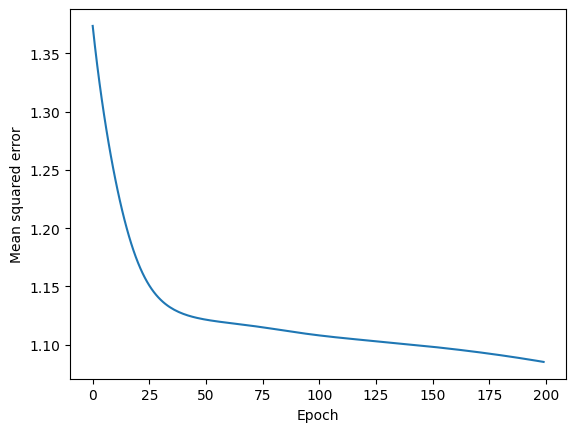

In [11]:
plt.plot(range(len(epoch_loss_test)), epoch_loss_test)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
plt.show()

## mlp pytorch in class

Add stratify from example code for randomness.

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1./3, random_state=1, stratify=y)

In [ ]:
X_train_norm = X_train.values.astype(np.float32)
X_test_norm  = X_test.values.astype(np.float32)
X_validation_norm = X_validation.values.astype(np.float32)

In [57]:
X_train_norm = torch.from_numpy(X_train_norm).float()
y_train      = torch.from_numpy(y_train.values.astype(np.int64))  # long for NLL/CE
X_test_norm  = torch.from_numpy(X_test_norm).float()
y_test       = torch.from_numpy(y_test.values.astype(np.int64))
X_validation_norm = torch.from_numpy(X_validation_norm).float()

In [58]:
train_ds = TensorDataset(X_train_norm, y_train)

In [59]:
torch.manual_seed(1)
batch_size = 128        
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [60]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Softmax(dim=1)(x)
        return x

In [61]:
input_size  = X_train_norm.shape[1]
hidden_size = 64
output_size = 2         
model = Model(input_size, hidden_size, output_size)

In [62]:
loss_fn = nn.CrossEntropyLoss()

In [63]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [64]:
num_epochs = 100
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

for epoch in range(num_epochs):

    for x_batch, y_batch in train_dl:
        pred = model(x_batch)                             
        loss = loss_fn(pred, y_batch.long())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()

    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)

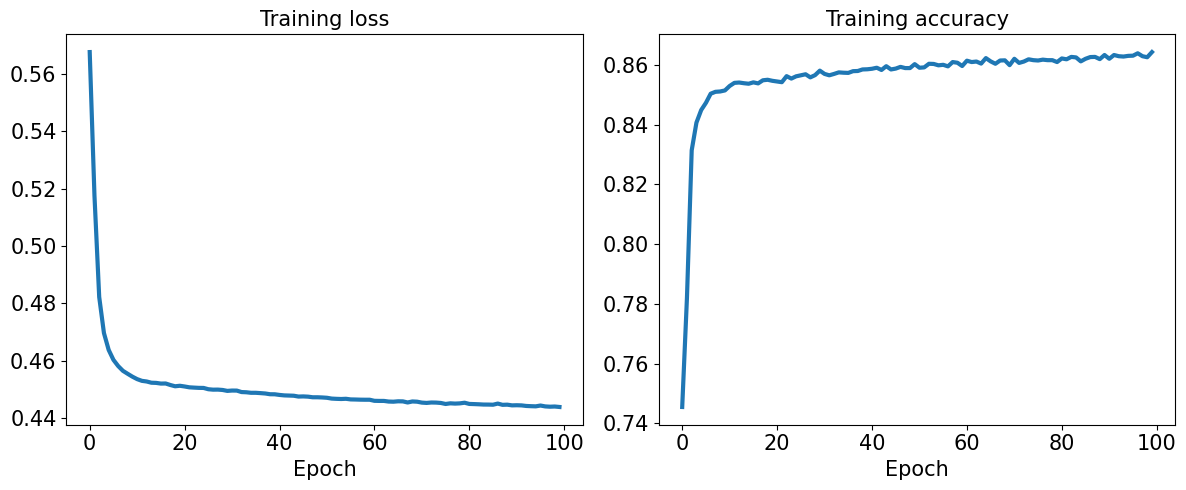

In [65]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()

In [66]:
pred_test = model(X_test_norm)
correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.8528


In [67]:
path = 'income.pt'
torch.save(model, path)
model_new = torch.load(path, weights_only=False)
model_new.eval()

Model(
  (layer1): Linear(in_features=91, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=2, bias=True)
)

In [75]:
pred_test = model_new(X_test_norm)
correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean().item()
print(f"\nTest Acc.: {accuracy:.4f}")


Test Acc.: 0.8528


In [ ]:
path = 'income_state.pt'
torch.save(model.state_dict(), path)

In [72]:
model_new = Model(input_size, hidden_size, output_size)
model_new.load_state_dict(torch.load(path))
model_new.eval()
print("\n", model_new)


 Model(
  (layer1): Linear(in_features=91, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=2, bias=True)
)


In [74]:
pred_val = model_new(X_validation_norm)           
preds_val = torch.argmax(pred_val, dim=1).cpu().numpy()  
preds_final = np.where(preds_val == 1, 1, -1)
pd.DataFrame({"prediction": preds_final}).to_csv("Group_9_MLP_PredictedOutputs.csv", index=False)

## Reflection and Conceptual Questions

### Why did you choose the specific architecture (e.g., number of layers, activation functions) for each model?

### How did you monitor and mitigate overfitting in your models?

### What ethical concerns might arise from deploying models trained on these datasets?

### Why are activation functions necessary in neural networks?